# Kmapper script for all pools

This script applies kmapper to the cleaned and interpolated LTRM data. Included is two different functions that will utilize different clustering functions (DBSCAN and HDBSCAN). Prior to using kmapper, the data is standardized using robust scaling and dummy variables are created for 'STRATUM', 'POOL', and 'YEAR' so that the kmapper output can be colored by categorical variables.

## Import libraries

In [5]:
import kmapper as km
from kmapper.plotlyviz import *

import sklearn
#from sklearn import ensemble
# DBSCAN from sklearn for clustering algorithms
from sklearn.cluster import DBSCAN
# PCA from sklearn for projection/lens creation
from sklearn.decomposition import PCA
# from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# scipy for interpolation
# import scipy 
# from scipy.interpolate import *
import hdbscan
import pickle as pk
import json as js
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer

# Plotly and Dash
import plotly.graph_objs as go
from kmapper.plotlyviz import plotlyviz
from kmapper.plotlyviz import *
from ipywidgets import (HBox, VBox)
import dash_html_components as html
import dash_core_components as dcc
import dash
from ipywidgets import interactive, HBox, VBox, widgets, interact
import warnings
warnings.filterwarnings("ignore")

## Upload data

In [6]:
import pandas as pd
water20 = pd.read_csv("../../LTRM data/RF interpolation/water_full.csv")
water20 = water20[["SHEETBAR", "DATE", "LATITUDE","LONGITUDE","FLDNUM", "STRATUM","LOCATCD",
"TN","TP","TEMP", "DO", "TURB", "VEL", "SS", "WDP", "CHLcal",  "SECCHI", "YEAR", "SEASON"]]

## Robust Scaling

In [7]:
continuous_variables = ["TN","TP","TEMP", "DO", "TURB", "VEL", "SS", "WDP", "CHLcal",  "SECCHI"]

ct = ColumnTransformer([('somename', RobustScaler(), continuous_variables)], remainder = 'passthrough')

water_df = ct.fit_transform(water20)

water_df = pd.DataFrame(water_df, columns = ["TN","TP","TEMP", "DO", "TURB", "VEL", "SS", "WDP", "CHLcal",  "SECCHI",
                                             "SHEETBAR", "DATE", "LATTITUDE","LONGITUDE","FLDNUM", "STRATUM","LOCATCD",
                                             "YEAR", "SEASON"])     

## Make 'DECADE' column

In [ ]:
#for index, row in water_df.iterrows():
#    water_df['93-00'] = np.where((water_df['YEAR'] <= 2000), 1, 0)
#    water_df['98-04'] = np.where((water_df['YEAR' >= 1998]) & (water_df['YEAR'] <= 2004), 1, 0)
#    water_df['01-13'] = np.where((water_df['YEAR'] >= 2001) & (water_df['YEAR'] <= 2013), 1, 0)
#    water_df['10-16'] = np.where((water_df['YEAR'] >= 2010) & (water_df['YEAR'] <= 2016), 1, 0)
#    water_df['14-20'] = np.where((water_df['YEAR'] >= 2014), 1, 0)

eco_time_periods = ['1993-2000', '1898-2004', '2001-2013', '2010-2016', '2014-2020']

for time_period in eco_time_periods:
    begin_year = int(time_period[0:4])
    end_year = int(time_period[5:9])
    
    water_df[time_period] = np.where((water_df['YEAR'] >= begin_year) & (water_df['YEAR'] <= end_year), 1, 0)

## Make dummy variables for coloring by categorical variable

In [9]:
to_dummy_vars = ['STRATUM', 'FLDNUM']

for var in to_dummy_vars:
    temp = pd.get_dummies(water_df[var])
    water_df = pd.concat([water_df, temp], axis = 1)

## Plot the distribution of standard variables

In [ ]:
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(water_df)
ax = fig.add_subplot(111)

bp = ax.boxplot(water_df, patch_artist = True,
                notch ='True', vert = 1)

ax.set_xticklabels(["1", "2", "3", "4", "5", "6", "7", "8", "9", "10",
                    "WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"])

ax.set_ylim(-5, 20)
ax.get_yaxis().set_visible(False)

#ax.set_yticklables([-5, 0, 5, 10, 15, 20])

plt.title("Distribution of standardized variables")
 
# show plot
plt.show(bp)

## Kmapper functions

* mapper_func_hdb - implements kmapper using HDBSCAN
* mapper_func - implements kmapper using DBSCAN

In [12]:
def mapper_func_hdb(df, HDB_MIN_CLUSTER = 45, HDB_MIN_SAMP = 10, 
                    N_CUBES = [10,10], PERC_OVERLAP = [.25,.25], draw_bool = True):
    """
    """
    X = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]]

    # for discerning primary variables in PCA 
    continuous_variables = ["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]
    
    
    var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
    projected_vars = continuous_variables
    projected_var_indices = [var_to_index[var] for var in projected_vars]
    
#     if X.shape[0]<10:
#         #print(X)
#         print("Not enough data in ", title, "_size = ", X.shape[0])
#         return(X.shape[0])
    
    # to match up indices in scomplex with the original dataframe X
    X.reset_index(drop = True, inplace = True)
    df.rest_index(drop = True, inplace = True)
    
    # create instance of clustering alg
    cluster_alg = hdbscan.HDBSCAN(min_cluster_size = HDB_MIN_CLUSTER, min_samples = HDB_MIN_SAMP)

    # instantiate kepler mapper object
    mapper = km.KeplerMapper(verbose = 0)
    
    # defining filter function as projection on to the first 2 component axis
    pca = PCA(n_components = 2)
    lens = pca.fit_transform(X)
    
    #for j in range(2):
    #    pc_j = pca.components_[j]
    #    largest_magnitude = max(abs(pc_j))
    #    idx_magnitude = np.where(abs(pc_j) == largest_magnitude)[0][0]
        

        #print("*** PCA", j + 1, " ***")
        #print("Primary variable: ", continuous_variables[idx_magnitude])
        #print("Corresponding component: ", pc_j[idx_magnitude])
        #print("Explained variance: ", pca.explained_variance_ratio_[j])
    
    # Generate the simplicial complex
    scomplex = mapper.map(lens, X, 
                          cover = km.Cover(n_cubes = N_CUBES, perc_overlap = PERC_OVERLAP), 
                          clusterer = cluster_alg)  

    if draw_bool == True: 
        summary_variable = mapper.project(np.array(X), projection = projected_var_indices, scaler = None)

        pl_brewer = [[0.0, '#006837'],
                [0.1, '#1a9850'],
                [0.2, '#66bd63'],
                [0.3, '#a6d96a'],
                [0.4, '#d9ef8b'],
                [0.5, '#ffffbf'],
                [0.6, '#fee08b'],
                [0.7, '#fdae61'],
                [0.8, '#f46d43'],
                [0.9, '#d73027'],
                [1.0, '#a50026']]

        color_function_name = ["FLDNUM"]
        color_values = df['year'] # X['PREDICTED_TP]
        #color_values = X['TURB']
        my_colorscale = pl_brewer
        kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex, 
                                                                        color_values,  
                                                                        color_function_name = color_function_name, 
                                                                        colorscale = my_colorscale)

        bgcolor = 'rgba(10,10,10, 0.9)'
        # y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey

        plotly_graph_data = plotly_graph(kmgraph, graph_layout ='fr', colorscale = my_colorscale, 
                                        factor_size = 2.5, edge_linewidth = 0.5)

        plot_title =  'LTRM: MinClust '+ str(HDB_MIN_CLUSTER) + ', MIN_SAMPLES ' + str(HDB_MIN_SAMP) 
        # plot_title = 'Pool 13, Summer 1993-1999; Epsilon ' + str(DBSCAN_EPSILON) + ', MIN_SAMPLES ' + str(DBSCAN_MIN_SAMPLES) 
        
        layout = plot_layout(title = plot_title,  
                            width = 620, height = 570,
                            annotation_text = get_kmgraph_meta(mapper_summary),  
                            bgcolor = bgcolor)

        # FigureWidget is responsible for event listeners
        fw_graph = go.FigureWidget(data = plotly_graph_data, layout = layout)
        fw_hist = node_hist_fig(colorf_distribution, bgcolor = bgcolor)
        fw_summary = summary_fig(mapper_summary, height = 300)

        dashboard = hovering_widgets(kmgraph, 
                                    fw_graph, 
                                    bgcolor = bgcolor, 
                                    member_textbox_width = 600)

        # DESIRED FILE PATH, CHANGE TO FIT YOUR LOCAL MACHINE
        #directory_path = "../kmapper"
        
        #Update the fw_graph colorbar, setting its title:
        fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'
        html_output_path = 'HDB_PCA_2' + 'MinC_' + str(HDB_MIN_CLUSTER) +'MinS_' + str(HDB_MIN_SAMP) + 'NCUBES_' + str(N_CUBES) + 'PEROvLp_' + str(PERC_OVERLAP) + '.html'
        
        mapper.visualize(scomplex, color_values = color_values, color_function_name = color_function_name, 
                        path_html = html_output_path, lens = summary_variable, lens_names = continuous_variables)
        
    return scomplex, X
    
def mapper_func(df, DBSCAN_EPSILON = 20, DBSCAN_MIN_SAMPLES = 20, N_CUBES = [10, 10], PERC_OVERLAP = [.45, .45], draw_bool = True):
    
    X = df[["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]]
    continuous_variables =  ["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]

    var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
    #projected_vars = continuous_variables
    projected_var_indices = [var_to_index[var] for var in continuous_variables]

    # defining clustering and kmapper parameters
    # create instance of clustering alg
    cluster_alg = sklearn.cluster.DBSCAN(eps = DBSCAN_EPSILON, min_samples = DBSCAN_MIN_SAMPLES, metric = 'euclidean')

    # Instantiate kepler mapper object
    mapper = km.KeplerMapper(verbose = 0)
    
    # defining filter function as projection on to the first 2 component axis
    pca = PCA(n_components = 2)
    lens = pca.fit_transform(X)

    #pca.fit_transform(X)
    principle_component = max(abs(pca.components_[0].min()), abs(pca.components_[0].max()))
    max_index = 0

    for i in range(len(pca.components_[0])):
        if abs(pca.components_[0][i]) == principle_component:
            max_index = i

    #print("Primary variable: ", continuous_variables[max_index])
    #print("Corresponding component: ", pca.components_[0][max_index])
    #print('Explained Variance: ', pca.explained_variance_ratio_)
    
    #lens = np.array(X[continuous_variables[max_index]])
    #lens = np.array(X[['PredictedTN', 'PredictedSS']])
    
    # Generate the simplicial complex
    scomplex = mapper.map(lens, X, cover = km.Cover(n_cubes = N_CUBES, perc_overlap = PERC_OVERLAP), 
                                                    clusterer = cluster_alg, remove_duplicate_nodes = True)  

    if draw_bool == True:
        summary_variable = mapper.project(np.array(X), projection = projected_var_indices, scaler = None)

        pl_brewer = [[0.0, '#006837'],
                [0.1, '#1a9850'],
                [0.2, '#66bd63'],
                [0.3, '#a6d96a'],
                [0.4, '#d9ef8b'],
                [0.5, '#ffffbf'],
                [0.6, '#fee08b'],
                [0.7, '#fdae61'],
                [0.8, '#f46d43'],
                [0.9, '#d73027'],
                [1.0, '#a50026']]

        color_function_name = ["TN"]
        color_values = df['TN']
        #color_values = lens [:,0] - lens[:,0].min() # X['PREDICTED_TP]
        #color_values = X['TURB']
        my_colorscale = pl_brewer
        kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex, 
                                                                        color_values,  
                                                                        color_function_name = color_function_name, 
                                                                        colorscale = my_colorscale)

        bgcolor = 'rgba(10,10,10, 0.9)'
        # y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey

        plotly_graph_data = plotly_graph(kmgraph, graph_layout ='fr', colorscale = my_colorscale, 
                                        factor_size = 2.5, edge_linewidth = 0.5)

        plot_title =  'LTRM: Epsilon '+ str(DBSCAN_EPSILON) + str(DBSCAN_EPSILON) + ', MIN_SAMPLES ' + str(DBSCAN_MIN_SAMPLES) 
        # plot_title = 'Pool 13, Summer 1993-1999; Epsilon ' + str(DBSCAN_EPSILON) + ', MIN_SAMPLES ' + str(DBSCAN_MIN_SAMPLES) 
        


        layout = plot_layout(title = plot_title,  
                            width = 620, height = 570,
                            annotation_text = get_kmgraph_meta(mapper_summary),  
                            bgcolor = bgcolor)

        # FigureWidget is responsible for event listeners
        fw_graph = go.FigureWidget(data = plotly_graph_data, layout = layout)
        fw_hist = node_hist_fig(colorf_distribution, bgcolor = bgcolor)
        fw_summary = summary_fig(mapper_summary, height = 300)

        dashboard = hovering_widgets(kmgraph, 
                                    fw_graph, 
                                    bgcolor = bgcolor, 
                                    member_textbox_width = 600)

        # DESIRED FILE PATH, CHANGE TO FIT YOUR LOCAL MACHINE
        #directory_path = "../kmapper"
        
        #Update the fw_graph colorbar, setting its title:
        fw_graph.data[1].marker.colorbar.title = 'dist to<br>x-min'

        html_output_path = 'PCA_2' + 'Eps_' + str(DBSCAN_EPSILON) +'MinS_' + str(DBSCAN_MIN_SAMPLES) + 'NCUBES_' + str(N_CUBES) + 'PEROvLp_' + str(PERC_OVERLAP) + '.html'
        
        mapper.visualize(scomplex, color_values = color_values, color_function_name = color_function_name, 
                        path_html = html_output_path, lens = summary_variable, lens_names = continuous_variables)
        
    return scomplex, X

In [13]:
test, X_test = mapper_func(water_df, DBSCAN_EPSILON = 1.2, DBSCAN_MIN_SAMPLES = 20, N_CUBES = [125, 125], PERC_OVERLAP = [.4, .4], draw_bool = True)

## Running kmapper with several combinations of parameters

In [47]:
epsilon_list = [5, 10, 15]
cubes_list = [50, 75, 100]

for i in epsilon_list:
    for j in cubes_list:
        scomplex, X = mapper_func(water_df, i, 10, [j, j], [.5, .5], True)



## Running TDA on different subsets of the data 

### DBSCAN subsets

In [27]:
mapper_hdb_output_dict = {}
mapper_hdb_output_df = {}

subset_perc = [.25, .5, 1]
for i in subset_perc: 
    TEMP_DATA = water_df.sample(n = int(i * len(water_df)))
    print("DATA SIZE: " + str(int(i * len(water_df))))
    title = str(int(i* 100)) + '% SUBSET: MinClust_' + str(10) + '_MinSamp_' + str(10)
    print(title)

    scomplex, X = mapper_func_hdb(TEMP_DATA, 10, 10, [75,75], [.5,.5])
    mapper_hdb_output_dict[title] = scomplex
    mapper_hdb_output_df[title] = X
    
    plotlyviz(scomplex, title = 'HDB', graph_layout = 'fr', dashboard = True)

DATA SIZE: 19167
25% SUBSET: MinClust_10_MinSamp_10
DATA SIZE: 38334
50% SUBSET: MinClust_10_MinSamp_10
DATA SIZE: 76669
100% SUBSET: MinClust_10_MinSamp_10


In [28]:
import json as js
json = js.dumps(mapper_hdb_output_dict)
f = open("HDB_graphs.json","w")
f.write(json)
f.close()

import pickle as pk
pickle = pk.dump(mapper_hdb_output_df, open("HDB_dfs.p","wb"))

### HDBSCAN subsets

In [29]:
mapper_output_dict = {}
mapper_output_df = {}

subset_perc = [.25, .5, 1]
for i in subset_perc: 
    TEMP_DATA = water_df.sample(n = int(i * len(water_df)))
    print("DATA SIZE: " + str(int(i * len(water_df))))
    title = str(int(i* 100)) + '% SUBSET: EPSILON_' + str(1) + '_MinSamp_' + str(10)
    print(title)

    scomplex, X = mapper_func(TEMP_DATA, 1, 10, [75,75], [.5,.5])
    mapper_output_dict[title] = scomplex
    mapper_output_df[title] = X
    
    plotlyviz(scomplex, title = 'HDB', graph_layout = 'fr', dashboard = True)


DATA SIZE: 19167
25% SUBSET: EPSILON_1_MinSamp_10
DATA SIZE: 38334
50% SUBSET: EPSILON_1_MinSamp_10
DATA SIZE: 76669
100% SUBSET: EPSILON_1_MinSamp_10


In [31]:
import json as js
json = js.dumps(mapper_output_dict)
f = open("DB_graphs.json","w")
f.write(json)
f.close()

import pickle as pk
pickle = pk.dump(mapper_output_df, open("DB_dfs.p","wb"))

## Making different HTML outputs with different color options

In [44]:
"""
- assigns name lists for coloring functions
- runs kmapepr function

"""
X = water_df[["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]]
continuous_variables =  ["WDP", "SECCHI", "TEMP", "DO", "TURB", "VEL", "TP", "TN", "SS", "CHLcal"]

pool_names = ['Unexploded Ordinance Area - Pool 13',
                                        'Bellevue, IA',
                                        'Brighton, IL',
                                          'Havana, IL',
                                         'Jackson, MO',
                                       'Lake City, MN',
                                        'Onalaska, WI']

year_names = [1993, 1994,1995,1996,1997,1998,1999,2000,2001,2002,2004,2005,
              2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,
              2018,2019, 2020]

stratum_names = ['Backwater area contiguous to the main channel',
                                           'Impounded',
                                            'Isolated',
                             'Lake Pepin or Swan Lake',
                                        'Main channel',
                                        'Side channel']

var_to_index = {continuous_variables[i] : i for i in range(len(continuous_variables))}
projected_var_indices = [var_to_index[var] for var in continuous_variables]

cluster_alg = sklearn.cluster.DBSCAN(eps = 10, min_samples = 10, metric = 'euclidean')
#cluster_alg = hdbscan.HDBSCAN(min_cluster_size = 10, min_samples = 10)
pca = PCA(n_components = 2)
lens = pca.fit_transform(X)

mapper = km.KeplerMapper(verbose = 0)
scomplex = mapper.map(lens, X, cover = km.Cover(n_cubes = [75, 75], perc_overlap = [.5, .5]), 
                                            clusterer = cluster_alg, remove_duplicate_nodes = True)  


In [48]:
"""
- coloring portion of the code - used primarily for the HTML outputs, not plotlyvis
- to change the coloring, make sure color_vals, color_names, and plot title is changed

    
summary_variable = mapper.project(np.array(X), projection = projected_var_indices, scaler = None)

# Make HTML with color values as the continous variables
color_vals = water_df[continuous_variables]
color_names = continuous_variables
kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex, 
                                                                    color_values = color_vals,
                                                                    color_function_name = color_names)

#for node in kmgraph['nodes']:
#    node['custom_tooltips'] = np.array(water_df[variable])[scomplex['nodes'][node['name']]]

#plotly_graph_data = plotly_graph(kmgraph, graph_layout = 'fr', factor_size = 2.5, edge_linewidth = 0.5)

"""
    layout = plot_layout(title = 'LTRM DATA',  
                        width = 620, height = 570,
                        annotation_text = get_kmgraph_meta(mapper_summary))


html_output_path = 'DBSCAN_NON_STANDARDIZED_CONTINUOUS_VARS.html'
    
mapper.visualize(scomplex, color_values = color_vals, color_function_name = color_names, 
                path_html = html_output_path, lens = summary_variable, lens_names = continuous_variables)


KeyboardInterrupt: 

In [27]:
nodes = scomplex["nodes"]
keys = scomplex["nodes"].keys()
lengths = []
for key in keys:
    lengths.append(len(nodes.get(key)))


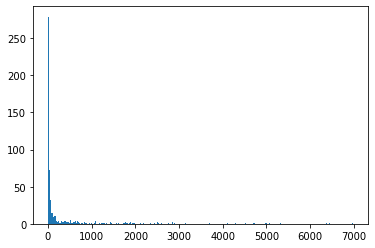

In [37]:
plt.hist(lengths, bins = 350)
plt.xlabel = ('Node count')
plt.ylabel = ('Frequency')
plt.show()
plt.close()